<a href="https://colab.research.google.com/github/ssabuj/ML_Code_Writing/blob/feature%2Fjupyters/DQN_Agent_Arch1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import pylab
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [2]:
!mkdir save_graph
!mkdir save_model

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size, action_space):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = action_space

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        self.epsilon_max = 1.0
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.01
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

        #self.Q_dict = collections.defaultdict(dict)
        self.Q_dict = collections.defaultdict(dict)
        self.States_track = collections.defaultdict(dict)

        print(len(self.Q_dict))
        print(len(self.States_track))

       
    # Initialise states to be tracked
    def initialise_tracking_states(self):
        sample_q_values = [((2, 12, 2), (4, 2)),
                           ((2, 16, 2), (0, 2)),
                           ((2, 18, 2), (2, 0)),
                           ((2, 15, 1), (0, 0)),
                           ((2, 15, 1), (4, 2)),
                           ((3, 15, 4), (4, 2))
                          ]
        for q_values in sample_q_values:
            state = q_values[0]
            action = q_values[1]
            self.States_track[state][action] = [] 

    def add_to_dict(self,state):
        state1 = state
        if state1 not in self.Q_dict.keys():
            for action in self.action_space:
                self.Q_dict[state1][action]=0
            
    #Defining a function to save the Q-dictionary as a pickle file
    def save_obj(self, obj, name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
    def save_tracking_states(self):
        for state in self.States_track.keys():
            for action in self.States_track[state].keys():
                if state in self.Q_dict and action in self.Q_dict[state]:
                    self.States_track[state][action].append(self.Q_dict[state][action])
                
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        model.summary()    
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model



    def get_action(self, env, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        indx, action_list = env.requests(state)

        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-0.0009*time)

        z = np.random.random()     
        
        if np.random.rand() <= self.epsilon:    
            return random.choice(action_list)
        else:
            q_value = self.model.predict([env.state_encod_arch1(state)])
            return self.action_space[np.argmax(q_value[0])]
            
   

    def append_sample(self, state, action, reward, next_state, terminal_state):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        #print((state,action))
        self.memory.append((state, action, reward, next_state, terminal_state))

    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
                
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            states, actions, rewards, terminal_states = [], [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                #state_encod = env.state_encod_arch2(next_state)
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                states.append(state)
                terminal_states.append(terminal_state)
                update_output[i] = env.state_encod_arch1(next_state)
                           
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)


            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            qvalue_total=0
            for i in range(self.batch_size):
                action = self.action_space.index(actions[i])
                if terminal_states[i]:
                    target[i][action] = rewards[i]
                else: # non-terminal state
                    target[i][action] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                self.Q_dict[states[i]][actions[i]] += target[i][action]
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            

    def save(self, name):
        self.model.save(name)

In [6]:
Episodes = 2000

### DQN block

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1184      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                693       
Total params: 2,933
Trainable params: 2,933
Non-trainable params: 0
_________________________________________________________________
0
0
episode: 0   score: -29.0   memory length: 130   epsilon: 1.0
7.832629442214966
episode: 1   score: -175.0   memory length: 268   epsilon: 0.9991094008297421
episode: 2   score: -200.0   memory length: 413   epsilon: 0.9982196028381529
episode: 3   score: -90.0   memory length: 556   epsilon: 0.997330605304496
episode: 4   score: -315.0   memory length: 703   epsilon: 0.9964424

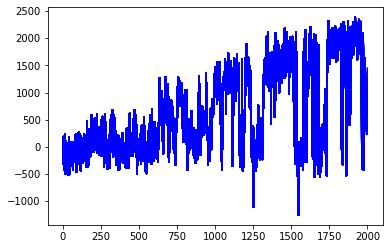

In [7]:
scores, episodes = [], []
# Write code here
# Call the environment
# Call all the initialised variables of the environment
start_time = time.time()
env = CabDriver()
state_size = env.state_size
action_size = env.action_size
action_space = env.action_space
agent = DQNAgent(state_size, action_size, action_space)
agent.initialise_tracking_states()

for episode in range(Episodes):
    #Call the DQN agent
    terminal_state= False
    action_space, state_space, state= env.reset()
    agent.add_to_dict(state)
    count = 0
    score = 0
    while not terminal_state:
        count += 1
        action = agent.get_action(env, state, episode)
        
        reward = env.reward_func(state,action,Time_matrix)
        next_state,terminal_state = env.next_state_func(state,action,Time_matrix)  
        agent.add_to_dict(next_state)
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        if count %50 == 0:
            agent.train_model()
        
        score += reward
        state = next_state
            
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
            #save the model 
    scores.append(score)
    episodes.append(episode)
    pylab.plot(episodes, scores, 'b')
    pylab.savefig("./save_graph/cabdriver_dqn.png")
    print("episode:", episode, "  score:", score, "  memory length:", len(agent.memory), "  epsilon:", agent.epsilon)
    agent.save_tracking_states()
    
    if episode % 50 == 0:
        agent.model.save("./save_model/cabdriver_dqn.h5")
        agent.save_tracking_states()
        agent.save_obj(agent.States_track,'States_tracked')   
        agent.save_obj(agent.Q_dict,'Policy')       
        elapsed_time = time.time() - start_time
        print(elapsed_time)
        

### Tracking Convergence

In [8]:
agent.States_track

defaultdict(dict,
            {(2,
              12,
              2): {(4, 2): [0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0,
               0

2040
2040
2036
2040
2040
2027


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


<function matplotlib.pyplot.show>

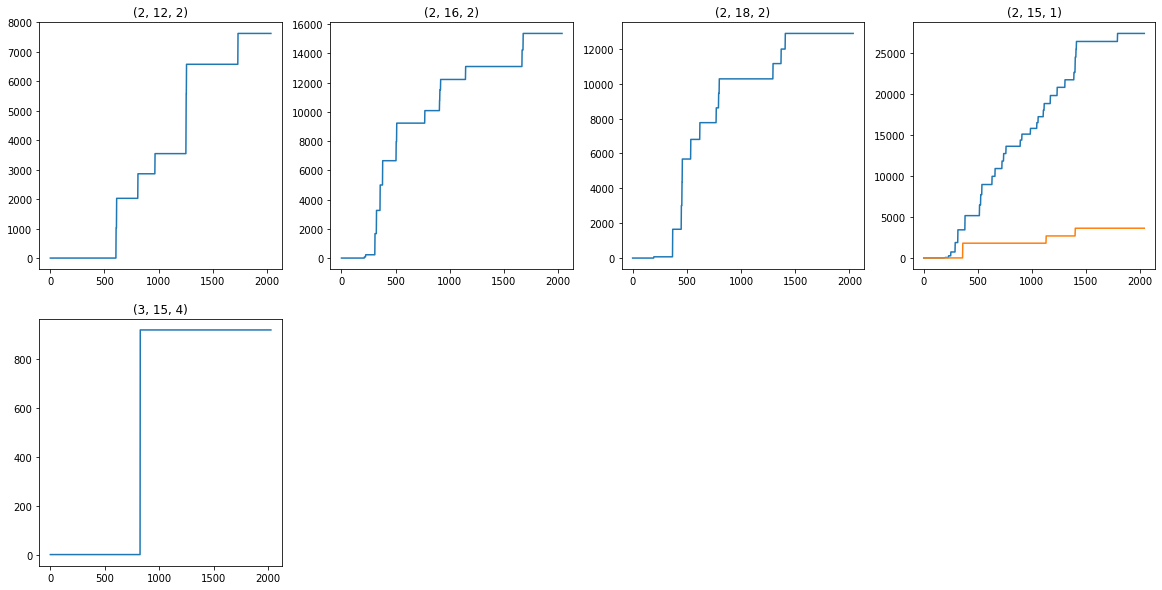

In [10]:
plt.figure(0, figsize=(20,10))
plt_init=240
for key, value in agent.States_track.items():
    plt_init = plt_init+1
    for k,v in value.items():
        print(len(v))
        xaxis = np.asarray(range(0, len(v)))
        yaxis = np.asarray(v)
        plt.subplot(plt_init)
        plt.title(str(key))
        plt.plot(xaxis,yaxis)
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()